In [1]:
from torchvision import transforms
from torchvision import datasets as ch_datasets

from robustness.tools.label_maps import CLASS_DICT

from standard_utils import *
from decision_tree_utils import *
from visualize_utils import *

In [2]:
IMAGENET_PATH = '/scratch1/shared/datasets/ILSVRC2012/'

class_index = 845 # index of the ImageNet class
grouping = 'prediction' # can be either: label, prediction, (prediction is used in the paper)
model_name = 'standard' # can be either: 'standard' or 'robust'

assert ((grouping == 'prediction') or (grouping == 'label'))
assert ((class_index >= 0) and (class_index < 1000)), class_index


class_names = CLASS_DICT['ImageNet']

# Failure explanation sample

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class ImageNetSubset(Dataset):
    def __init__(self, imagenet_path, class_index, grouping, model_name):
        self.labels = np.load('metadata/train_labels.npy')
        self.preds =  np.load('metadata/' + model_name + '_train_preds.npy')
        
        if grouping == 'label':
            image_indices = np.nonzero(self.labels == class_index)[0]
        elif grouping == 'prediction':
            image_indices = np.nonzero(self.preds == class_index)[0]
        else:
            raise ValueError('Unknown grouping: {:s}. Must be either: prediction/label.'.format(grouping))

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()])

        self.imagenet = ch_datasets.ImageNet(root = imagenet_path, split = 'train') 
        self.image_indices = image_indices

        self.class_indices_dict = {}
        for class_index in range(1000):
            class_name = class_names[class_index]
            self.class_indices_dict[class_name] = class_index

    def __len__(self):
        return len(self.image_indices)

    def __getitem__(self, index):
        image_index = self.image_indices[index]
        image, _ = self.imagenet.__getitem__(image_index)
        image = self.transform(image)

        label_index = self.labels[image_index]
        label = class_names[label_index]
        
        pred_index = self.preds[image_index]
        prediction = class_names[pred_index]
        
        return image, label, prediction

In [6]:
def failure_explanation(imagenet_path, class_name, grouping, model_name = "standard"):
    robust_model_name = 'robust_resnet50.pth'
    robust_model = load_robust_model()
    
    imagenet_subset = ImageNetSubset(imagenet_path, class_name, grouping, model_name)
        
    train_features, train_labels, train_preds = extract_features(robust_model, imagenet_subset)
    
    train_success = (train_preds == train_labels)
    train_failure = np.logical_not(train_success)
    
    train_base_error_rate = np.sum(train_failure)/len(train_failure)
    
    sparse_features, feature_indices = select_important_features(train_features, train_failure, 
                                                                 num_features=50, method='mutual_info')    
    print(feature_indices)
    
    decision_tree = train_decision_tree(sparse_features, train_failure, 
                                        max_depth=1, criterion="entropy")
    train_precision, train_recall, train_ALER = decision_tree.compute_precision_recall(
        sparse_features, train_failure)
    
    class_name = class_names[class_index]
    
    
    
    print_with_stars(" Training Data Summary ", prefix="\n")
    print('Grouping by {:s} for class name: {:s}'.format(grouping, class_name))
    print('Number of correctly classified: {:d}'.format(np.sum(train_success)))
    print('Number of incorrectly classified: {:d}'.format(np.sum(train_failure)))
    print('Total size of the dataset: {:d}'.format(len(train_failure)))
    print('Train Base_Error_Rate (BER): {:.4f}\n'.format(train_base_error_rate))

    print_with_stars(" Decision Tree Summary (evaluated on training data) ")
    print('Tree Precision: {:.4f}'.format(train_precision))
    print('Tree Recall: {:.4f}'.format(train_recall))
    print('Tree ALER (ALER of the root node): {:.4f}\n'.format(train_ALER))

    
    error_rate_array, error_coverage_array = decision_tree.compute_leaf_error_rate_coverage(
                                                sparse_features, train_failure)

    important_leaf_ids = important_leaf_nodes(decision_tree, error_rate_array, error_coverage_array)
    for leaf_id in important_leaf_ids[:1]:
        leaf_precision = error_rate_array[leaf_id]
        leaf_recall = error_coverage_array[leaf_id]

        decision_path = decision_tree.compute_decision_path(leaf_id)

        print_with_stars(" Failure statistics for leaf[{:d}] ".format(leaf_id))
        print('Leaf Error_Rate (ER): {:.4f}'.format(leaf_precision))
        print('Leaf Error_Coverage (EC): {:.4f}'.format(leaf_recall))
        print('Leaf Importance_Value (IV): {:.4f}'.format(leaf_precision*leaf_recall))

        
        leaf_failure_indices = decision_tree.compute_leaf_truedata(sparse_features, 
                                                                   train_failure, leaf_id)
        display_failures(leaf_id, leaf_failure_indices, imagenet_subset, grouping, num_images=6)
        
        print_with_stars(" Decision tree path from root to leaf[{:d}] ".format(leaf_id))
        for node in decision_path:
            node_id, feature_id, feature_threshold, direction = node
            
            if direction == 'left':
                print_str = "Feature[{:d}] < {:.6f} (left branching, lower feature activation)".format(
                    feature_id, feature_threshold)
            else:
                print_str = "Feature[{:d}] > {:.6f} (right branching, higher feature activation)".format(
                    feature_id, feature_threshold)

            print(print_str)
        print("")
        
        print_with_stars(" Visualizing features on path from root to leaf[{:d}] ".format(leaf_id))
        print("")
        display_images(decision_path, imagenet_subset, robust_model, train_features, 
                       feature_indices, grouping, num_images=6)

=> loading checkpoint './models/robust_resnet50.pth'
=> loaded checkpoint './models/robust_resnet50.pth' (epoch 105)
[1601  897 1947  256 1821 1200  595   60 1431  137 1211 1466 1270 1628
 1566  961  410  929  458 1527 1816  638 1957 1568 1198  983  445  226
  380 1885  699 1767 1206 1687 1534  409 1091  440  618  766 1259  768
 1583 1964 1062 1966  377  940  420 1117]

********************************************** Training Data Summary **********************************************
Grouping by prediction for class name: syringe
Number of correctly classified: 1122
Number of incorrectly classified: 284
Total size of the dataset: 1406
Train Base_Error_Rate (BER): 0.2020

******************************* Decision Tree Summary (evaluated on training data) ********************************
Tree Precision: 0.3519
Tree Recall: 0.4894
Tree ALER (ALER of the root node): 0.2455

***************************************** Failure statistics for leaf[1] ******************************************
Le

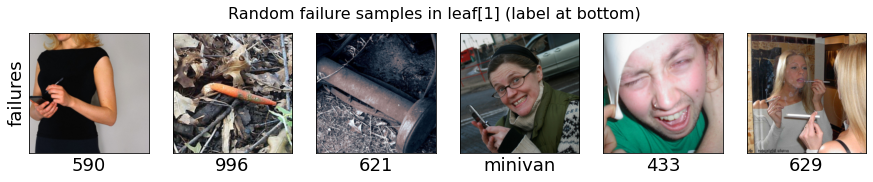

Class index: 590 ==> Class name: hand-held computer, hand-held microcomputer
Class index: 996 ==> Class name: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
Class index: 621 ==> Class name: lawn mower, mower
Class index: 433 ==> Class name: bathing cap, swimming cap
Class index: 629 ==> Class name: lipstick, lip rouge

************************************* Decision tree path from root to leaf[1] *************************************
Feature[21] < 0.232549 (left branching, lower feature activation)

******************************** Visualizing features on path from root to leaf[1] ********************************

******************************************** Visualizing feature[638] *********************************************


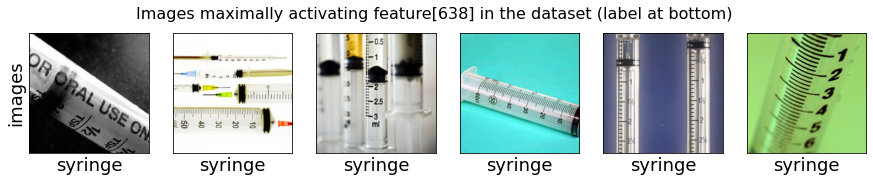

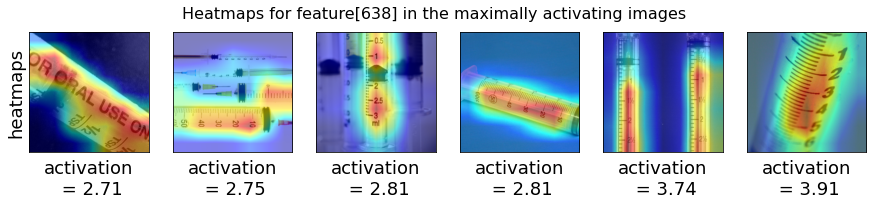

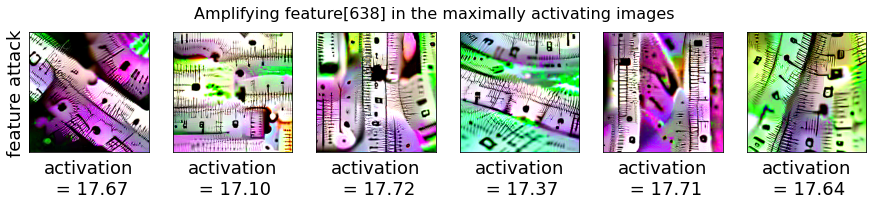

In [7]:
failure_explanation(IMAGENET_PATH, class_index, grouping, model_name)